In [1]:
'''
FloodFill modified to traverse the entire image and output different color.
TODO: Sequential Labeling: https://www.youtube.com/watch?v=ticZclUYy88
TODO: do a pre-process-3 for tumor cells
TODO: filter out components based on area to entire image area ratio.
'''

'\nFloodFill modified to traverse the entire image and output different color.\n'

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [3]:
options = {
    'img_dir': './img'
}

In [61]:
def get_unique_colors(img):
    return (np.unique(img.reshape(-1, img.shape[2]), axis=0))

def getNextNewColor(usedColors):
    newColor = (np.random.choice(range(256), size=3))
    while np.any([np.all(uc == newColor) for uc in usedColors]): # if newColor matches any of the oldColors
        newColor = (np.random.choice(range(256), size=3))
    return newColor

def floodfill(surface, x, y, oldColors, usedColors):
    if surface[x][y] not in oldColors: # Has new color already. No need to look.
        return surface, usedColors

    colorOfFocus = surface[x][y].copy()
    newColor = getNextNewColor(usedColors)    
    usedColors = np.vstack([usedColors, newColor])

    # Add first coord into stack
    theStack = [(x, y)]
    
    while len(theStack) > 0:
        x, y = theStack.pop()
        
        if x < 0 or x > surface.shape[0]-1 or y < 0 or y > surface.shape[1]-1: # Out of Bounds
            continue
        
        if np.all(surface[x][y] == colorOfFocus):
            surface[x][y] = newColor
            theStack.append((x+1, y))  # right
            theStack.append((x-1, y))  # left
            theStack.append((x, y+1))  # down
            theStack.append((x, y-1))  # up

    return surface, usedColors

def flood_fill_multi(img, debug=False):
    oldColors = get_unique_colors(img)
    usedColors = get_unique_colors(img)
    
    if debug:
        print("Used Colors")
        plt.imshow(usedColors)
        plt.show()

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img, usedColors = floodfill(img, i, j, oldColors, usedColors)

    return img, usedColors

def gen_color_key(color):
    return "_".join(str(channel) for channel in color)

def get_largest_components(img, usedColors, n=2):
    h = {}    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            color = img[i][j]re
            color_key = gen_color_key(color)
            if color_key in h.keys():
                h[color_key] += 1
            else:
                h[color_key] = 1

    h_desc = [item[0] for item in sorted(h.items(), key = lambda kv:(kv[1], kv[0]))]
    h_desc_rev_filt = list(reversed(h_desc))[:n]
    top_n_components = [[int(ck) for ck in colorkey.split('_')] for colorkey in h_desc_rev_filt]
    return top_n_components

def filter_out_colors(img, colors, bgColor):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            curr_color = img[i][j]
            if not np.any([np.all(c == curr_color) for c in colors]):
                img[i][j] = bgColor
    return img

Orig img


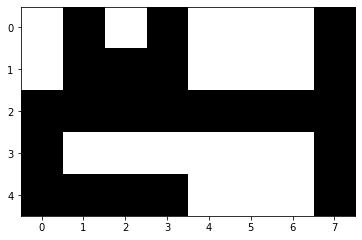

Used Colors


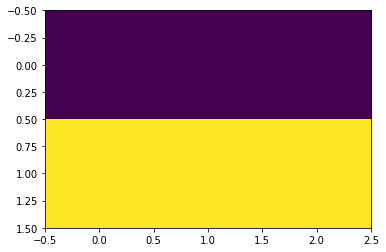

[[  0   0   0]
 [255 255 255]
 [100 171 248]
 [  4  64 114]
 [  4 240 230]
 [ 56 124 135]
 [250  46 190]]
FloodFill | after


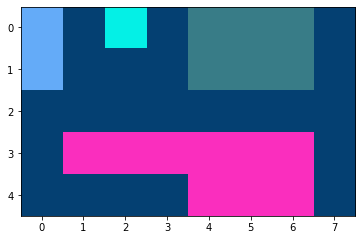

largest_colors [[4, 64, 114], [250, 46, 190], [56, 124, 135]]


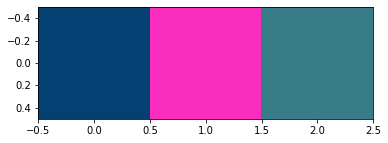

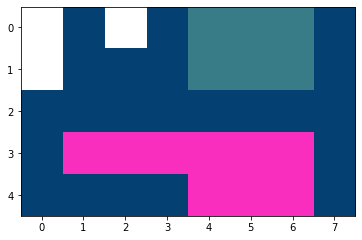

In [173]:
def test_flood_fill_multi():
    a = np.array([[(255,255,255), (0,0,0), (255,255,255), (0,0,0), (255,255,255), (255,255,255), (255,255,255), (0,0,0)],
                 [(255,255,255), (0,0,0), (0,0,0), (0,0,0), (255,255,255), (255,255,255), (255,255,255), (0,0,0)],
                 [(0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0)],
                 [(0,0,0), (255,255,255), (255,255,255), (255,255,255), (255,255,255), (255,255,255), (255,255,255), (0,0,0)],
                 [(0,0,0), (0,0,0), (0,0,0), (0,0,0), (255,255,255), (255,255,255), (255,255,255), (0,0,0)]])

    print("Orig img")
    plt.imshow(a)
    plt.show()

    a, usedColors = flood_fill_multi(a, debug=True)

    print(usedColors)
    print("FloodFill | after")
    plt.imshow(a)
    plt.show()

    largest_colors = get_largest_components(a, usedColors, n=3)
    print("largest_colors", largest_colors)
    plt.imshow(np.array([largest_colors]))
    plt.show()

    img = filter_out_colors(a, largest_colors, [255, 255, 255])
    plt.imshow(img)
    plt.show()

test_flood_fill_multi()

In [292]:
def img_preprocess_1(img):
    kernel_10x10 = np.ones((10,10),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_10x10) # Open. Fill in any holes.
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_10x10) # Open. Fill in any holes.
    img = cv2.GaussianBlur(img, (5,5), 0)

    _, img = cv2.threshold(img,250,255,cv2.THRESH_BINARY)
    return img

def img_preprocess_2(img):
    kernel_5x5 = np.ones((5,5),np.uint8)
    kernel_3x3 = np.ones((3,3),np.uint8)

    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_5x5) # Open. Fill in any holes.
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_3x3) # Close. Remove small blob
    _, img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    return img

def img_preprocess_3(img):
    kernel_10x10 = np.ones((10,10),np.uint8)
    kernel_7x7 = np.ones((7,7),np.uint8)
    kernel_3x3 = np.ones((3,3),np.uint8)
    
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_10x10) # Close. Remove small blob    
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_10x10) # Close. Remove small blob
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_7x7) # Close. Remove small blob
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_3x3) # Close. Remove small blob
    _, img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    return img

In [293]:
def get_connected_components(img_path, preprocess_mode, debug=False, output_res=False):
    # Open Hand
    print("img path=", img_path)  # options['img_dir'] + "/" + 'open-bw-full.png'
    img = cv2.imread(img_path)

    if debug:
        print("Original")
        plt.imshow(img)
        plt.show()

    if preprocess_mode == 1:
        img = img_preprocess_1(img)
    elif preprocess_mode == 2:
        img = img_preprocess_2(img)
    else:
        img = img_preprocess_3(img)

    img, usedColors, = flood_fill_multi(img, debug=debug)
    
    if debug:
        print("After preprocess and floodfill multi")
        plt.imshow(img)
        plt.show()

    largest_colors = get_largest_components(img, usedColors, n=3)
    if debug:
        print("Largest_colors", largest_colors)
        plt.imshow(np.array([largest_colors]))
        plt.show()
    
    largest_colors = largest_colors[1:]
    
    img = filter_out_colors(img, largest_colors, [255, 255, 255])
    if debug or output_res:
        print("After filter out smallest colors")
        plt.imshow(img)
        plt.show()
    
    return img, largest_colors

In [156]:

def get_next_cw_pos(center, curr): # TODO, p = center, b = current pos
#     '''
#     C is left of center. 
#     [[...],
#      [C center X]]
#     '''
    if curr[1] == center[1] and curr[0]+1 == center[0]: 
        return [curr[0], curr[1]-1]
#     '''
#     C is left-top of center. 
#     [[C X X],
#      [X center X]]
#      '''
    elif curr[1]+1 == center[1] and curr[0]+1 == center[0]: 
        return [curr[0]+1, curr[1]]
#     '''
#     C is top of center. 
#     [[X C X],
#      [X center X]]
#     '''
    elif curr[1]+1 == center[1] and curr[0] == center[0]: 
        return [curr[0]+1, curr[1]]
#     '''
#     C is top-right of center. 
#     [[X X C],
#      [X center X]]
#     '''
    elif curr[1]+1 == center[1] and curr[0]-1 == center[0]: 
        return [curr[0], curr[1]+1]
#     '''
#     C is right of center. 
#     [[X X X],
#      [X center C]]
#     '''
    elif curr[1] == center[1] and curr[0]-1 == center[0]: 
        return [curr[0], curr[1]+1]
#     '''
#     C is right-bot of center. 
#     [[X X X],
#      [X center X],
#      [X X C]]
#     '''
    elif curr[1]-1 == center[1] and curr[0]-1 == center[0]: 
        return [curr[0]-1, curr[1]]
#     '''
#     C is bot of center. 
#     [[X X X],
#      [X center X],
#      [X C X]]
#     '''
    elif curr[1]-1 == center[1] and curr[0] == center[0]: 
        return [curr[0]-1, curr[1]]
#     '''
#     C is left-bot of center. 
#     [[X X X],
#      [X center X],
#      [C X X]]
#     '''
    elif curr[1]-1 == center[1] and curr[0]+1 == center[0]: 
        return [curr[0], curr[1]-1]
#     '''
#     C is left of center. 
#     [[X X X],
#      [C center X],
#      [X X X]]
#     '''
    elif curr[1] == center[1] and curr[0]+1 == center[0]: 
        return [curr[0], curr[1]-1]
    else:
        print("ERROR")        

In [238]:
def test_get_next_cw_pos():
    # Test get_next_cw_pos
    img = np.array([[[0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0]],
                    [[0,0,0], [0,0,0], [0,0,0]]])

    center = [1,1]

    in_coord = [0,0]
    print("in({}). out({})".format(in_coord, get_next_cw_pos(center, in_coord)))
    in_coord = [1,0]
    print("in({}). out({})".format(in_coord, get_next_cw_pos(center, in_coord)))
    in_coord = [2,0]
    print("in({}). out({})".format(in_coord, get_next_cw_pos(center, in_coord)))
    in_coord = [2,1]
    print("in({}). out({})".format(in_coord, get_next_cw_pos(center, in_coord)))
    in_coord = [2,2]
    print("in({}). out({})".format(in_coord, get_next_cw_pos(center, in_coord)))
    in_coord = [1,2]
    print("in({}). out({})".format(in_coord, get_next_cw_pos(center, in_coord)))
    in_coord = [0,2]
    print("in({}). out({})".format(in_coord, get_next_cw_pos(center, in_coord)))
    in_coord = [0,1]
    print("in({}). out({})".format(in_coord, get_next_cw_pos(center, in_coord)))

test_get_next_cw_pos()

in([0, 0]). out([1, 0])
in([1, 0]). out([2, 0])
in([2, 0]). out([2, 1])
in([2, 1]). out([2, 2])
in([2, 2]). out([1, 2])
in([1, 2]). out([0, 2])
in([0, 2]). out([0, 1])
in([0, 1]). out([0, 0])


In [254]:
def boundary_tracing(img, target_colors, boundary_draw_color, debug=False):
    
    print("debug={}".format(debug))
    
    B = []
    ptColor = [255,255,255]
    start = None
    
#     print("shape:", img.shape)

    #   From bottom to top and left to right scan the cells of T until a black pixel, s, of P is found.
    for j in range(img.shape[0]):
        if start is not None:
            break
        for i in range(img.shape[1]):

            if start is not None:
                break
            
            if np.any([np.all(img[j][i] == tc) for tc in target_colors]): # is ptColor
                start = [i,j]
                if debug:
                    print("Found first black pixel (i,j) = ({})".format(start))

    if start is None:
        print("ERROR | Start is None")
        return None, None

    B.append(start)
    p = start
    b = [start[0]-1, start[1]] # TODO: border handle cases.
    c = get_next_cw_pos(p, b)
    if debug:
        print("About to start. Next move is c={}, b={}".format(c,b))

    while not np.all(c == start): # while c != start
        if c[0] < 0 or c[0] > img.shape[1]-1 or c[1] < 0 or c[1] > img.shape[0]-1: # Out of bounds
            b = c
            c = get_next_cw_pos(p, b)
            if debug:
                print("out of bounds. Continue . Next move is c={}, b={}".format(c,b))
        elif np.any([np.all(img[c[1]][c[0]] == tc) for tc in target_colors]): # color at c is pointColor
            B.append(c)
            p = c
            c = get_next_cw_pos(p, b)
            if debug:
                print("Add c into B. Next move is B={}, c={}, b={}.".format(B,c,b))
        else:
            b = c
            c = get_next_cw_pos(p, b)
            if debug:
                print("No find black pixel. Next move is c={}, b={}".format(c,b))
                
                
    # Draw Boundary
    boundary_img = img.copy()
    for b_coord in B:
        boundary_img[b_coord[1]][b_coord[0]] = boundary_draw_color

    return B, boundary_img

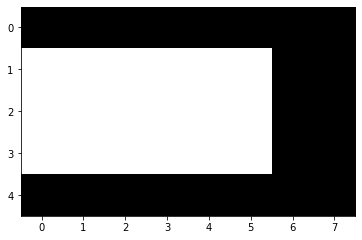

debug=True
Found first black pixel (i,j) = ([0, 1])
About to start. Next move is c=[-1, 0], b=[-1, 1]
out of bounds
No find black pixel. Next move is c=[1, 0], b=[0, 0]
No find black pixel. Next move is c=[1, 1], b=[1, 0]
Add c into B. Next move is B=[[0, 1], [1, 1]], c=[2, 0], b=[1, 0].
No find black pixel. Next move is c=[2, 1], b=[2, 0]
Add c into B. Next move is B=[[0, 1], [1, 1], [2, 1]], c=[3, 0], b=[2, 0].
No find black pixel. Next move is c=[3, 1], b=[3, 0]
Add c into B. Next move is B=[[0, 1], [1, 1], [2, 1], [3, 1]], c=[4, 0], b=[3, 0].
No find black pixel. Next move is c=[4, 1], b=[4, 0]
Add c into B. Next move is B=[[0, 1], [1, 1], [2, 1], [3, 1], [4, 1]], c=[5, 0], b=[4, 0].
No find black pixel. Next move is c=[5, 1], b=[5, 0]
Add c into B. Next move is B=[[0, 1], [1, 1], [2, 1], [3, 1], [4, 1], [5, 1]], c=[6, 0], b=[5, 0].
No find black pixel. Next move is c=[6, 1], b=[6, 0]
No find black pixel. Next move is c=[6, 2], b=[6, 1]
No find black pixel. Next move is c=[5, 2], b

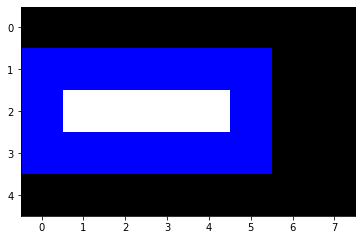

In [246]:
def test_boundary_tracing():
    # Input
    img = np.array([[[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]],
                 [[255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [0,0,0], [0,0,0]],
                 [[255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [0,0,0], [0,0,0]],
                 [[255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [255,255,255], [0,0,0], [0,0,0]],
                 [[0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0]]])

    plt.imshow(img)
    plt.show()

    # Boundary Tracing Algorithm
    boundary, boundary_img = boundary_tracing(img, [[255,255,255]], [0,0,255], debug=True)
    print("boundary=", boundary)
    plt.imshow(boundary_img)
    plt.show()
test_boundary_tracing()

img path= ./img/open-bw-full.png


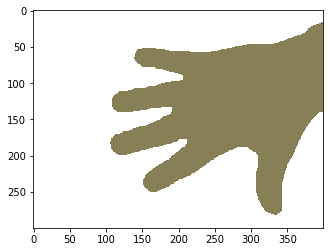

img path= ./img/open-bw-partial.png


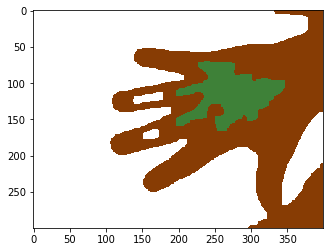

img path= ./img/open_fist-bw.png


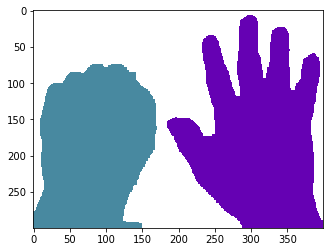

img path= ./img/tumor-fold.png


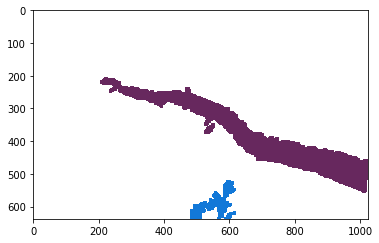

In [294]:
debug = False
output_res = False
open_full_cc, open_full_colors = get_connected_components(options['img_dir'] + "/" + 'open-bw-full.png', preprocess_mode=1, debug=debug, output_res=output_res)
plt.imshow(open_full_cc)
plt.show()

open_partial_cc, open_partial_colors = get_connected_components(options['img_dir'] + "/" + 'open-bw-partial.png', preprocess_mode=1, debug=debug, output_res=output_res)
plt.imshow(open_partial_cc)
plt.show()

open_fist_cc, open_fist_colors = get_connected_components(options['img_dir'] + "/" + 'open_fist-bw.png', preprocess_mode=2, debug=debug, output_res=output_res)
plt.imshow(open_fist_cc)
plt.show()

tumor_cc, tumor_colors = get_connected_components(options['img_dir'] + "/" + 'tumor-fold.png', preprocess_mode=3, debug=debug, output_res=output_res)
plt.imshow(tumor_cc)
plt.show()

debug=False


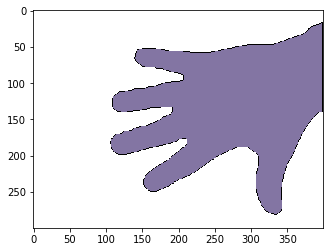

debug=False


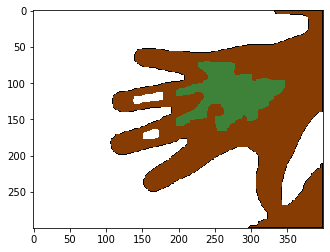

In [295]:
boundary, open_full_boundary_img = boundary_tracing(open_full_cc, open_full_colors, [0,0,0], debug=False)
plt.imshow(open_full_cc_boundary_img)
plt.show()


boundary, open_partial_boundary_img = boundary_tracing(open_partial_cc, open_partial_colors, [0,0,0], debug=False)
plt.imshow(open_partial_boundary_img)
plt.show()

debug=False


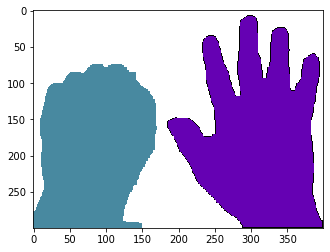

debug=False


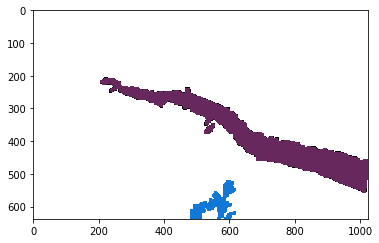

In [296]:
boundary, open_fist_boundary_img = boundary_tracing(open_fist_cc, open_fist_colors, [0,0,0], debug=False)
plt.imshow(open_fist_boundary_img)
plt.show()

boundary, tumor_boundary_img = boundary_tracing(tumor_cc, tumor_colors, [0,0,0], debug=False)
plt.imshow(tumor_boundary_img)
plt.show()

In [233]:

print(open_full_cc[100][100])



[254 184 250]
